In [68]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import torch
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader
from torchsampler import ImbalancedDatasetSampler

from dataloader.graph_ts_reader_30 import  MultiModalDataset, collate_fn
from dataloader.pyg_reader import global_node2idx_mapping
from model.final_model.risk.final_model_loss_train_risk import *
from model.final_model.risk.final_model_risk import PatientOutcomeModel
from model.retnet.autoencoder_v5_retnet import  TSAutoencoder
from model.final_model.risk.plot import *



import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()



In [69]:
# ===  get global node2index for graph data === 
hdf = '/home/mei/nas/docker/thesis/data/hdf/'
train_diagnoses = pd.read_hdf(f'{hdf}train/diagnoses.h5',key='df')
global_node2idx = global_node2idx_mapping(train_diagnoses)

# === load Dataset  ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

dataset_train = MultiModalDataset(train_data_dir,global_node2idx)
dataset_val = MultiModalDataset(val_data_dir,global_node2idx)
dataset_test = MultiModalDataset(test_data_dir,global_node2idx)


train_loader = DataLoader( dataset_train,batch_size=128,shuffle=True,collate_fn=collate_fn )
val_loader = DataLoader( dataset_val,batch_size=128,shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader( dataset_test,batch_size=128,shuffle=False,collate_fn=collate_fn )
train_loader_p = DataLoader(dataset_train, batch_size=128, shuffle=False, collate_fn=collate_fn)


Built 2150 patient-tree graphs
Built 461 patient-tree graphs
Built 461 patient-tree graphs


In [ ]:

flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === load pretrained model ===
pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30/stage6_higher_kappa/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer

# === load final model ===
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [ ]:
save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_30_debug"

model, history = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=50, save_dir=save_path, 
            gamma=100, beta=150, kappa=200,  theta=1, 
            patience = 20 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep20: Calculating global target P...


[Joint] Ep30: Calculating global target P...


[Joint] Ep40: Calculating global target P...


[Joint] Ep50: Calculating global target P...


[Joint] Early stopping at epoch 51 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


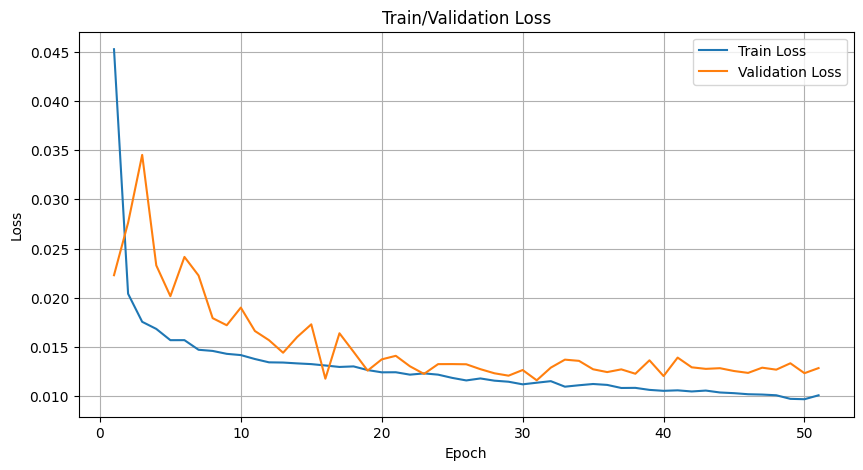

In [5]:
plot_training_history(history)

In [5]:
flat_input_dim = 104
hidden_dim = 128
graph_input_dim = 62
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pretrained =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)
pretrained.load_state_dict(torch.load(
"/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30/stage3/best_joint.pth", map_location=device,weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som_layer



model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30_v2/best_joint.pth'
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

In [6]:
output= test_patient_outcome_model(model, test_loader, device)

Test Risk    → RMSE: 0.1037


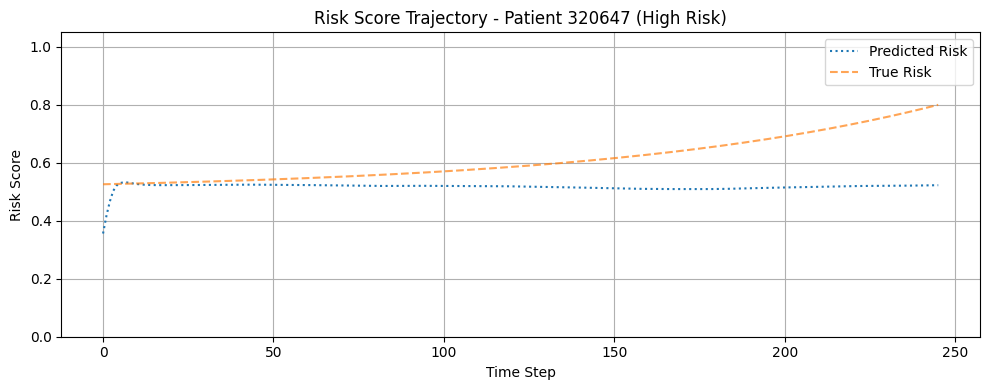

In [8]:
plot_patient_risk_score(model, test_loader, patient_index=398, device=device)

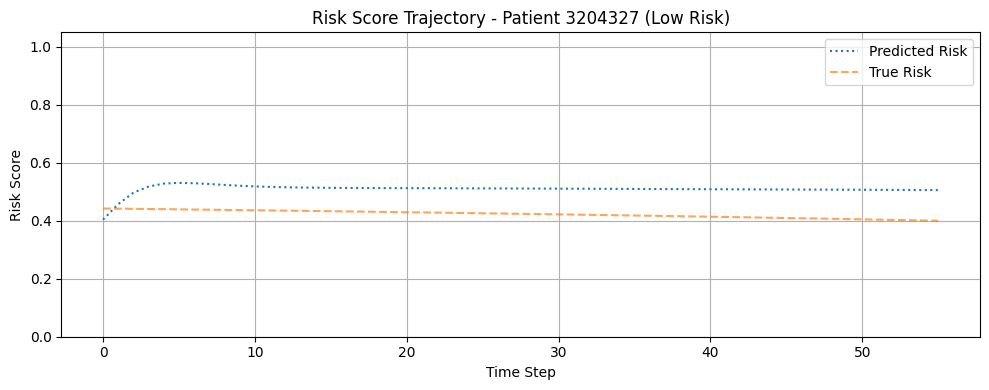

In [9]:
plot_patient_risk_score(model, test_loader, patient_index=397, device=device)

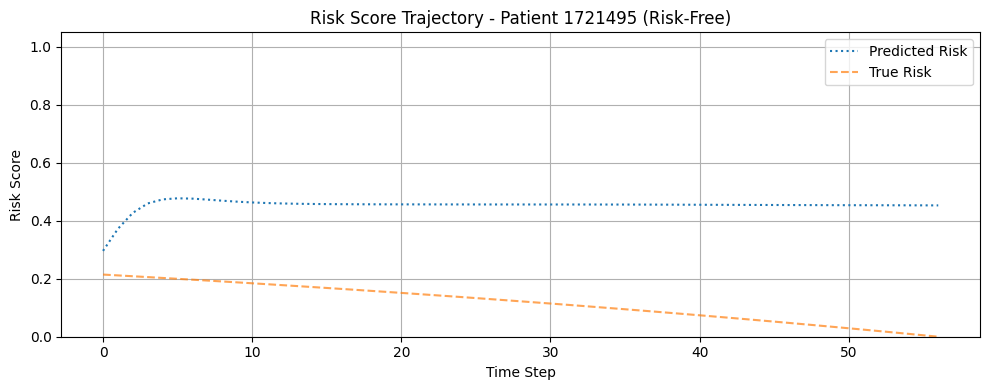

In [10]:
plot_patient_risk_score(model, test_loader, patient_index=51, device=device)

In [20]:
from matplotlib.colors import LogNorm
def plot_som_activation_heatmap(heatmap, som_dim, cmap="YlGnBu"):
    H, W = som_dim
    plt.figure(figsize=(W*0.6, H*0.6))
    sns.heatmap(
        heatmap,
        cmap=cmap,
        norm=LogNorm(vmin=max(heatmap.min(), 1e-3), vmax=heatmap.max()),
        annot=False,
        fmt="d",
        square=True,
        cbar_kws={"label": "Activation Count"}
    )
    plt.title("Overall SOM Activation")
    plt.xlabel("SOM Width")
    plt.ylabel("SOM Height")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

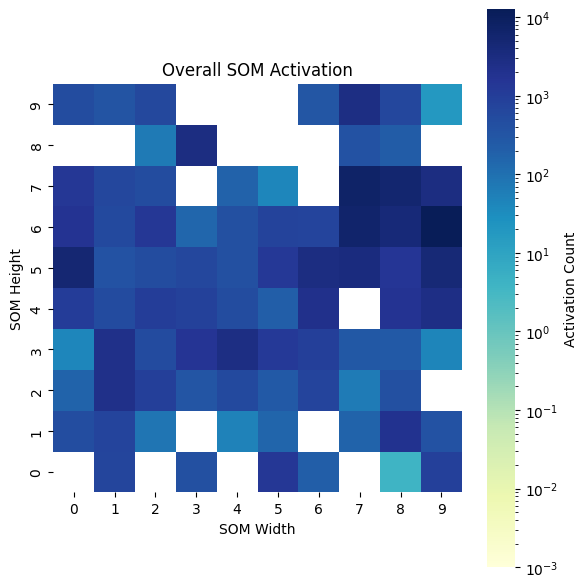

In [21]:

som_dim = (10,10)
activation_grid = compute_som_activation_heatmap(model, test_loader, device, som_dim)
plot_som_activation_heatmap(activation_grid, som_dim)

In [13]:
def plot_som_avg_risk(heatmap, som_dim, cmap="YlGnBu"):
    H, W = som_dim
    plt.figure(figsize=(W*0.6, H*0.6))
    sns.heatmap(
        heatmap,
        vmin=0.0, vmax=1.0,
        cmap=cmap,
        annot=True, fmt=".2f",
        # linewidths=.5, linecolor="gray"
    )
    plt.title("SOM Node Avg Risk")
    plt.xlabel("SOM Width"); plt.ylabel("SOM Height")
    plt.gca().invert_yaxis() #
    plt.tight_layout()
    plt.show()

--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


--> Heatmap computation complete.


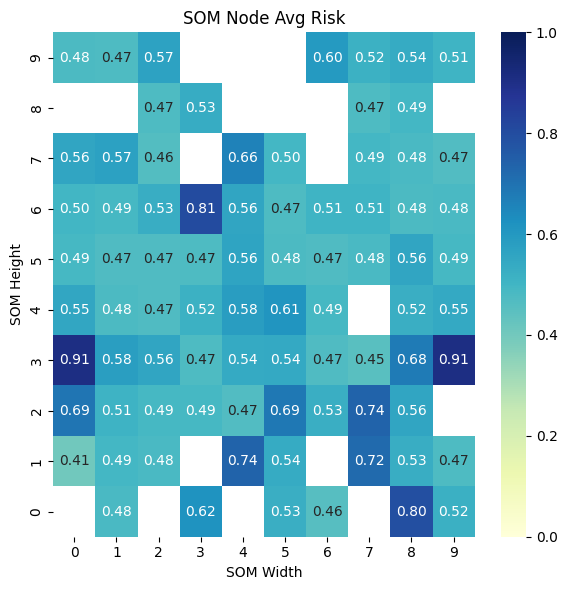

In [14]:

som_dim = (10,10)
avg_risk_map = compute_som_avg_risk(model, test_loader, device, som_dim)
plot_som_avg_risk(avg_risk_map, som_dim)

In [29]:
print_statistics_of_dataloader(test_loader)

test_loader 中 cat=0 的样本索引： [327, 194, 122, 161, 303, 123, 127, 51, 117, 109, 241, 279, 48, 61, 53, 302, 114, 18, 131, 77, 75, 88, 46, 43, 418, 71, 330]
cat=0 的患者 ID: [3118263, 2441148, 1848702, 2235716, 3064491, 1849239, 1854497, 1721495, 1842081, 1822777, 2642496, 2851573, 1718669, 1730209, 1722941, 3063135, 1833798, 1334230, 1857925, 1764355, 1762378, 1788553, 1364166, 1358338, 3232813, 1754475, 3123772]
cat=0 的样本长度: [475, 246, 152, 145, 80, 79, 58, 57, 55, 49, 49, 49, 48, 48, 47, 47, 44, 44, 44, 43, 42, 41, 39, 36, 36, 35, 32]
test_loader 中 cat=1 的样本索引： [15, 235, 28, 267, 286, 326, 98, 188, 380, 334, 52, 331, 240, 352, 273, 423, 56, 70, 42, 391, 179, 377, 217, 103, 140, 269, 356, 76, 40, 236, 408, 97, 130, 416, 315, 99, 208, 0, 372, 407, 319, 102, 126, 378, 347, 409, 219, 313, 368, 92, 72, 417, 111, 403, 447, 289, 31, 178, 81, 390, 229, 67, 115, 184, 3, 263, 419, 277, 439, 294, 274, 437, 268, 54, 264, 354, 259, 388, 191, 124, 311, 340, 233, 255, 105, 299, 246, 73, 5, 26, 35, 116, 1,

In [23]:
risk_heatmap = compute_som_avg_risk(model, test_loader, device, som_dim=(10, 10))

--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]

--> Heatmap computation complete.


--- Searching for specified patient IDs: ['1730209'] ---


Searching for patients:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Found 1 target(s) in current batch. Running forward pass...


Searching for patients:   0%|          | 0/4 [00:00<?, ?it/s]

    -> Computed trajectory for Patient ID: 1730209 (Category: 0)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [47]


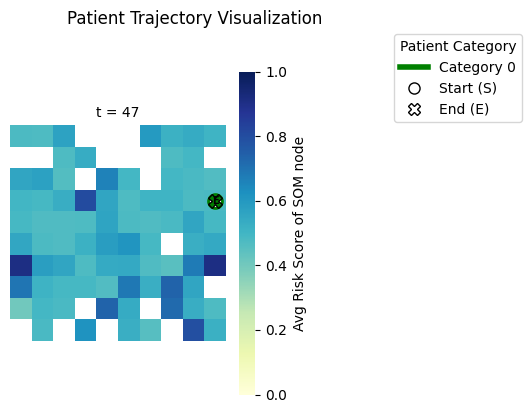

In [54]:
#cat=0
patient_ids = ['1730209'] 
#2642496, 2851573, 1718669, 1730209,
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['1341878'] ---


Searching for patients:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Found 1 target(s) in current batch. Running forward pass...


Searching for patients:   0%|          | 0/4 [00:00<?, ?it/s]

    -> Computed trajectory for Patient ID: 1341878 (Category: 1)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [528]


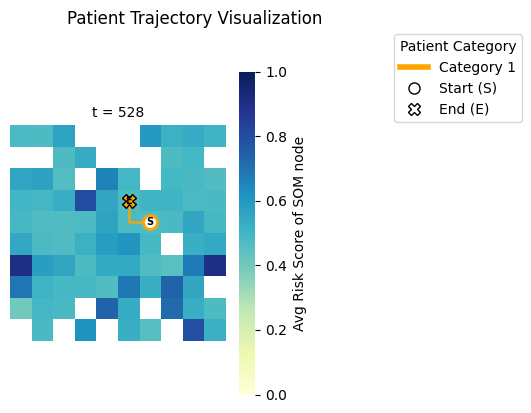

In [43]:
#cat=1
# 1753227, 1357048
# --- 2. 计算目标病人的轨迹 ---
patient_ids =  ['1341878']  
# 1327763, 2631475, 1341878, 2775718, 2879353
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

#开始，1/4处，1/2处，3/4处，和结束前一个点
# max_len // 2,  
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['2855985'] ---


Searching for patients:  50%|█████     | 2/4 [00:00<00:00,  2.77it/s]

  -> Found 1 target(s) in current batch. Running forward pass...
    -> Computed trajectory for Patient ID: 2855985 (Category: 2)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [522]


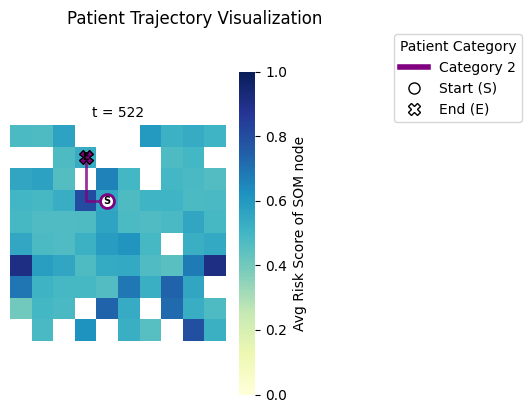

In [60]:
#cat=2
patient_ids = [ '2855985'] 
#  2600823, 2850001, 3218348, 2582452, 2855985,
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['2861911'] ---


Searching for patients:  50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

  -> Found 1 target(s) in current batch. Running forward pass...
    -> Computed trajectory for Patient ID: 2861911 (Category: 3)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [336]


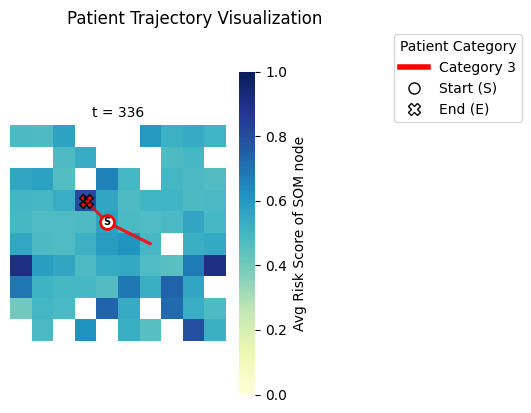

In [67]:
#cat=3
patient_ids = ['2861911'] 
# 3101154, 2452034, 2861911, 3120701, 3115071,
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

In [ ]:
# save_path2= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30_smooth"
# # save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_30_debug"

# model2, history2 = train_patient_outcome_model(model, 
#             train_loader, val_loader, train_loader_p, device, optimizer,  epochs=100, save_dir=save_path2, 
#             gamma=200, beta=200, kappa=150,  theta=1, 
#             patience = 20 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep20: Calculating global target P...


[Joint] Early stopping at epoch 26 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


In [ ]:
# best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30_smooth/best_joint.pth'
# model2 = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
# model2.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 15/15 [00:01<00:00,  8.01it/s]


--> Heatmap computation complete.


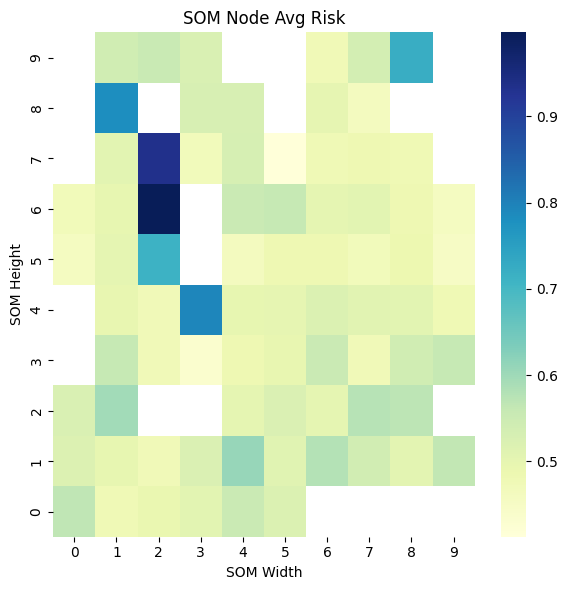

In [6]:

som_dim = (10,10)
avg_risk_map = compute_som_avg_risk(model2, test_loader, device, som_dim)
plot_som_avg_risk(avg_risk_map, som_dim)

In [ ]:
# --- 1. 计算热力图 ---
risk_heatmap = compute_som_avg_risk(model2, test_loader, device, som_dim=(10, 10))

In [53]:
def plot_trajectory_snapshots_custom_color(heatmap, trajectories, som_dim, snapshot_times,
                                           heatmap_cmap="YlGnBu", risk_point_cmap="coolwarm"):
    """
    Generates a series of plots showing multiple trajectories unfolding over time.
    Each trajectory has a main color based on its category, and its points are
    colored by risk at each timestep.

    Args:
        heatmap (np.ndarray): The background risk heatmap.
        trajectories (dict): Dictionary of trajectory data for one or more patients.
        som_dim (list): The dimensions of the SOM grid [H, W].
        snapshot_times (list): A list of timesteps at which to generate a plot snapshot.
        heatmap_cmap (str): Colormap for the background heatmap.
        risk_point_cmap (str): Colormap for the scatter points on the trajectory.
    """
    H, W = som_dim
    
    # --- 1. 创建子图画布 ---
    # 画布的列数等于快照的数量
    num_snapshots = len(snapshot_times)
    fig, axes = plt.subplots(1, num_snapshots, figsize=(W * num_snapshots * 0.4, H * 0.4))
    if num_snapshots == 1:
        axes = [axes] # 保证axes总是一个可迭代对象

    fig.suptitle("Patient Trajectory Visualization", fontsize=12, y=1.02)

    # --- 2. 准备颜色映射器 ---
    # a. 类别到主颜色的映射
    category_colors = { 0: 'green', 3: 'red', 1: 'orange', 2: 'purple' }
    default_color = 'gray'
    
    # b. 风险值到散点颜色的映射 (基于所有轨迹的全局风险范围)
    all_risks = np.concatenate([d["risk_sequence"] for d in trajectories.values() if len(d["risk_sequence"]) > 0])
    norm = Normalize(vmin=all_risks.min(), vmax=all_risks.max()) if len(all_risks) > 0 else None
    cmap_points = plt.get_cmap(risk_point_cmap)

    # --- 3. 遍历每个时间快照，绘制一个子图 ---
    for i, t in enumerate(snapshot_times):
        ax = axes[i]
        
        # a. 绘制背景热力图
        sns.heatmap(heatmap, cmap=heatmap_cmap, annot=False, cbar=True, cbar_kws={"label": "Avg Risk Score of SOM node"}, ax=ax, square=True)
        ax.invert_yaxis()
        ax.set_title(f"t = {t}", fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

        # b. 在当前子图上绘制所有轨迹直到时间点t的部分
        for sample_id, traj_data in trajectories.items():
            coords = traj_data["coords"]
            risks = traj_data["risk_sequence"]
            category = traj_data["category"]
            
            # 使用切片来获取从开始到当前快照时间点的所有数据
            current_t = min(t + 1, len(coords))
            if current_t == 0: continue # 如果一个点都没有，就不用画
            
            coords_slice = coords[:current_t]
            risks_slice = risks[:current_t]
            
            # 获取轨迹主颜色
            line_color = category_colors.get(category, default_color)

            # 准备坐标
            x_coords = np.array([c[0] + 0.5 for c in coords_slice])
            y_coords = np.array([c[1] + 0.5 for c in coords_slice])
            
            # 绘制轨迹线
            ax.plot(x_coords, y_coords, color=line_color, linestyle='-', linewidth=2, alpha=0.8, zorder=2)
            
            # 绘制风险着色的散点
            if norm:
                ax.scatter(x_coords, y_coords, c=risks_slice, cmap=cmap_points, norm=norm, 
                           s=50, zorder=3, ec='black', lw=0.5)

            # 只在第一个点上标记起点 'S'
            ax.plot(x_coords[0], y_coords[0], 'o', color='white', markersize=10, 
                    markeredgecolor=line_color, markeredgewidth=2, zorder=4)
            ax.text(x_coords[0], y_coords[0], 'S', color='black', ha='center', va='center', 
                    fontweight='bold', fontsize=7, zorder=5)
            
            # 在最后一个点上标记终点 'E'
            ax.plot(x_coords[-1], y_coords[-1], 'X', color=line_color, markersize=10, markeredgecolor='black', markeredgewidth=1, zorder=5)
            ax.text(x_coords[-1], y_coords[-1], 'E', color='black', ha='center', va='center',fontweight='bold', fontsize=7, zorder=6)

    # --- 4. 添加图例和共享的颜色条 ---
    # 创建一个代理图例
    legend_elements = [plt.Line2D([0], [0], color=color, lw=4, label=f'Category {cat}')
                       for cat, color in category_colors.items() if cat in [d['category'] for d in trajectories.values()]]
    start_proxy = plt.Line2D([0], [0],  marker='o', color='white', markeredgecolor='black', linestyle='None',  markersize=8, label='Start (S)')
    end_proxy   = plt.Line2D([0], [0],  marker='X', color='white',markeredgecolor='black', linestyle='None', markersize=8, label='End (E)')
    fig.legend(handles=legend_elements + [start_proxy, end_proxy], title="Patient Category", bbox_to_anchor=(0.98, 0.85), loc='center left')

    # 为风险散点创建一个共享的颜色条
    if norm:
        cbar_ax = fig.add_axes([0.85, 0.05, 0.04, 0.82]) # [left, bottom, width, height]
        sm = plt.cm.ScalarMappable(cmap=cmap_points, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax)
        cbar.set_label('Timepoint Risk Score')

    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()

--- Searching for specified patient IDs: ['2441148'] ---


Searching for patients:  40%|████      | 6/15 [00:08<00:11,  1.26s/it]

  -> Found 1 target(s) in current batch. Running forward pass...


Searching for patients:  40%|████      | 6/15 [00:11<00:16,  1.84s/it]

    -> Computed trajectory for Patient ID: 2441148 (Category: 0)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [245]



/tmp/ipykernel_3858599/3884251522.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


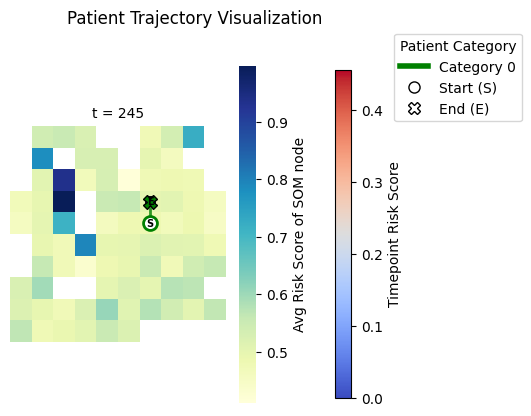

In [64]:
#cat=0
patient_ids = ['2441148'] 
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model2, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['1327763'] ---


Searching for patients:   0%|          | 0/15 [00:00<?, ?it/s]

  -> Found 1 target(s) in current batch. Running forward pass...


Searching for patients:   0%|          | 0/15 [00:02<?, ?it/s]

    -> Computed trajectory for Patient ID: 1327763 (Category: 1)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [529]



/tmp/ipykernel_3858599/3884251522.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


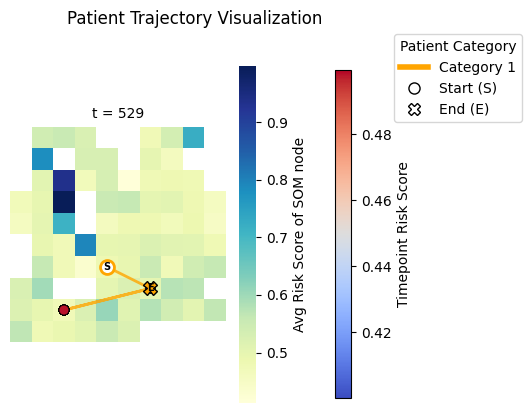

In [54]:
#cat=1
# --- 2. 计算目标病人的轨迹 ---
patient_ids =  ['1327763'] 

targeted_trajectories =  compute_trajectories_by_id_or_category(
    model2, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

#开始，1/4处，1/2处，3/4处，和结束前一个点
# max_len // 2,  
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['2850001'] ---


Searching for patients:  53%|█████▎    | 8/15 [00:11<00:10,  1.48s/it]

  -> Found 1 target(s) in current batch. Running forward pass...


Searching for patients:  53%|█████▎    | 8/15 [00:14<00:12,  1.81s/it]

    -> Computed trajectory for Patient ID: 2850001 (Category: 2)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [526]



/tmp/ipykernel_3858599/3884251522.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


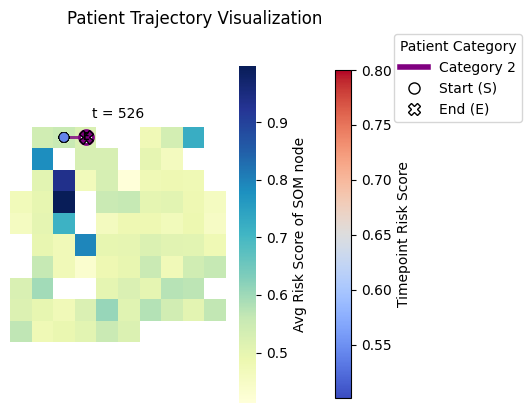

In [65]:
#cat=2
patient_ids = ['2850001'] 
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model2, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

--- Searching for specified patient IDs: ['2452034'] ---


Searching for patients:  40%|████      | 6/15 [00:08<00:11,  1.26s/it]

  -> Found 1 target(s) in current batch. Running forward pass...


Searching for patients:  40%|████      | 6/15 [00:10<00:16,  1.82s/it]

    -> Computed trajectory for Patient ID: 2452034 (Category: 3)
--- All target patients have been found. ---

Plotting trajectory snapshots at timesteps: [356]



/tmp/ipykernel_3858599/3884251522.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.8, 1])


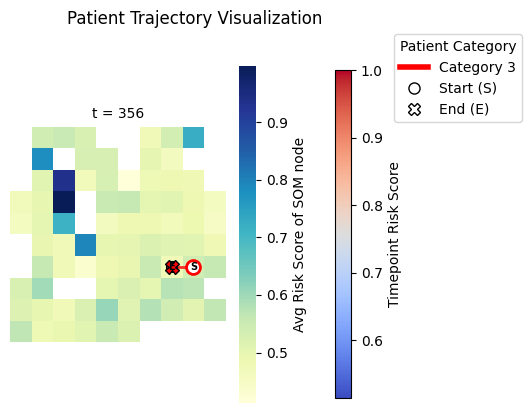

In [55]:
#cat=3
patient_ids = ['2452034'] 
targeted_trajectories =  compute_trajectories_by_id_or_category(
    model2, 
    test_loader, 
    device, 
    som_dim=(10,10),
    target_patient_ids=patient_ids 
)
    

# --- 3. 绘图 ---
max_len = max(len(d["coords"]) for d in targeted_trajectories.values())

# 开始，1/4处，1/2处，3/4处，和结束前一个点
snapshot_timesteps = [
    max_len - 1 
]

snapshot_timesteps = sorted(list(set(snapshot_timesteps))) 

print(f"\nPlotting trajectory snapshots at timesteps: {snapshot_timesteps}")

plot_trajectory_snapshots_custom_color(
    heatmap=risk_heatmap, 
    trajectories=targeted_trajectories, 
    som_dim=(10, 10),
    snapshot_times=snapshot_timesteps
)

## model 1 before smoothing

In [17]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30/best_joint.pth'
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 15/15 [00:34<00:00,  2.29s/it]


--> Heatmap computation complete.


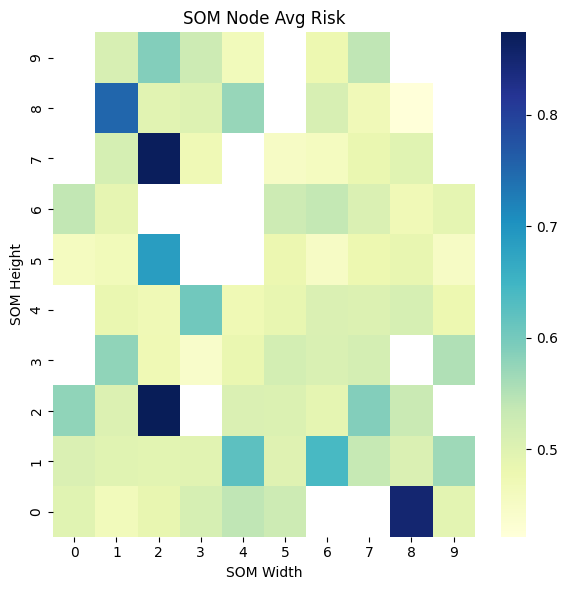

In [18]:

som_dim = (10,10)
avg_risk_map = compute_som_avg_risk(model2, test_loader, device, som_dim)
plot_som_avg_risk(avg_risk_map, som_dim)

# more weight to som

In [33]:
save_path2= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30_largestsom"
# save_path= "/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/combine/resampled_30_debug"

model2, history2 = train_patient_outcome_model(model, 
            train_loader, val_loader, train_loader_p, device, optimizer,  epochs=100, save_dir=save_path2, 
            gamma=400, beta=400, kappa=400,  theta=1, 
            patience = 20 )

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep20: Calculating global target P...


[Joint] Early stopping at epoch 24 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


In [5]:
best_model = '/home/mei/nas/docker/thesis/data/model_results/final_model_retnet/risk/resampled_30_largestsom/best_joint.pth'
model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device) 
model.load_state_dict(torch.load(best_model,weights_only=True))

<All keys matched successfully>

--- Computing SOM Average Risk Heatmap ---


Calculating heatmap: 100%|██████████| 15/15 [00:47<00:00,  3.18s/it]


--> Heatmap computation complete.


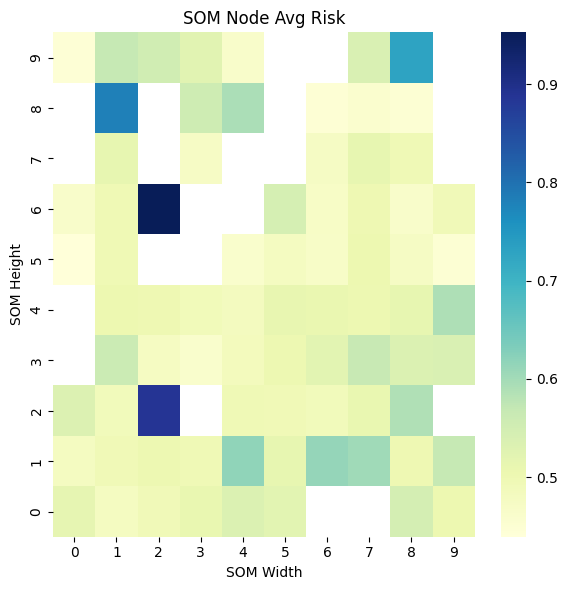

In [7]:
som_dim = (10,10)
avg_risk_map = compute_som_avg_risk(model, test_loader, device, som_dim)
plot_som_avg_risk(avg_risk_map, som_dim)